图片缩放与插值算法
===

# 1.最近邻域插值算法(Nearest-neighbor Interpolation)
假设原图片为src，目标图片为dst，那么就有
$$\begin{cases}
dstX&=srcX \times \frac{srcH}{dstH} \\
dstY&=srcY \times \frac{srcW}{dstW}
\end{cases}$$

最近邻插值在图像放大时补充的像素取最临近的像素的值。由于方法简单(采用了浮点数四舍五入)，所以处理速度很快，但是放大图像画质劣化明显。

# 2.双线性插值算法

双线性插值考察4邻域的像素点，并根据距离设置权值。虽然计算量增大使得处理时间变长，但是可以有效抑制画质劣化。




双线性插值运算量大，但是缩放后的质量比较高，而且具有低通滤波器的性质，所以可能会使图像轮廓在一定程度上变得模糊

1. 放大后图像坐标$(x',y')$除以放大率$\alpha$,可以得到对应原图像的坐标$(\lfloor \frac{x'}{\alpha} \rfloor,\lfloor \frac{y'}{\alpha} \rfloor)$
2. 求原图像的座标$(\lfloor \frac{x'}{a}\rfloor , \lfloor \frac{y'}{a}\rfloor)$周围4邻域的座标$I(x,y)，I(x+1,y)，I(x,y+1)，I(x+1,y+1)$
![images](Images/01/09/04_001.png)
3. 分别求这4个点与$(\frac{x'}{a}, \frac{y'}{a})$的距离，根据距离设置权重：$w = \frac{d}{\sum\ d}$
4. 根据下列公式求得放大后图像$(x',y')$处的像素值

$$\begin{split}
d_x &= \frac{x'}{a} - x \\
d_y &= \frac{y'}{a} - y \\
I'(x',y') &= (1-d_x)\  (1-d_y)\  I(x,y) + d_x\  (1-d_y)\  I(x+1,y) + (1-d_x)\  d_y\  I(x,y+1) + d_x\  d_y\  I(x+1,y+1)
\end{split}$$

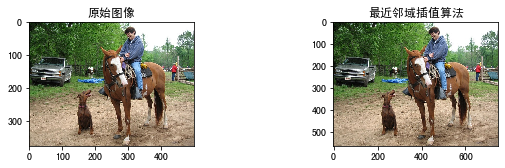

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

ratio = 1.5
image = cv2.imread("Images/01/09/02.jpg", 1)

def Interpo(img):
    shapes = img.shape
    height = shapes[0]
    width = shapes[1]
    dst_height = int(height * ratio)
    dst_width = int(width * ratio)
    dst_image = np.zeros((dst_height, dst_width, 3), dtype=np.uint8)

    for x in range(0, dst_height):
        for y in range(0, dst_width):
            dst_X = int(x * (height * 1.0 / dst_height))
            dst_Y = int(y * (width * 1.0 / dst_width))
            dst_image[x, y] = image[dst_X, dst_Y]
    return dst_image

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 2, 1)
plt.title(u"原始图像")
show_img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img1)

plt.subplot(2, 2, 2)
plt.title(u"最近邻域插值算法")
show_img2 = cv2.cvtColor(Interpo(image), cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)